Deep learning models, while achieving state-of-the-art performance on many tasks, are susceptible to adversarial attacks that exploit inherent vulnerabilities in their architectures. Adversarial attacks manipulate the input data with imperceptible perturbations, causing the model to misclassify the data or produce erroneous outputs. Szegedy et al. [1] discovered that Deep Neural Network models can be manipulated into making wrong predictions by adding small perturbations to the input image.
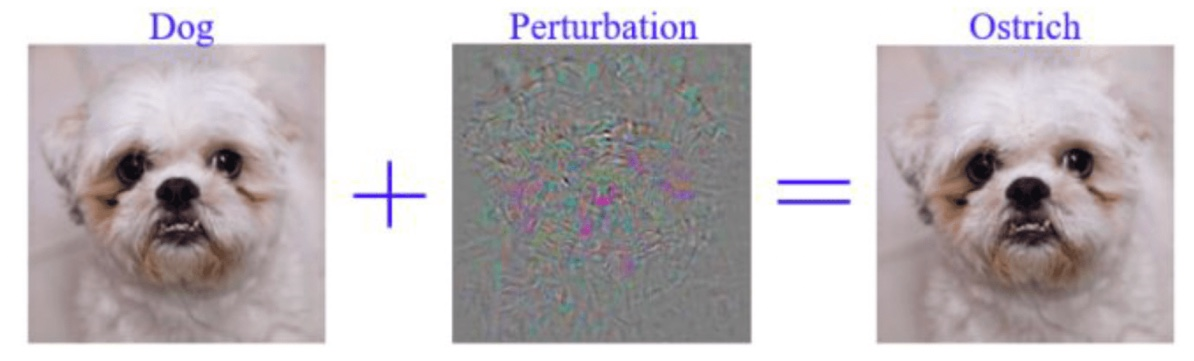
<center>Fig 1: Szegedy et al. were able to fool AlexNet by classifying a perturbed image of a dog into an ostrich<center/>

In [1]:
!pip install torchsummary

In [2]:
# Import libraries and packages

# Using PyTorch
import torch
import torchvision
from torchvision import transforms, datasets, models
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,random_split

from torchsummary import summary

from PIL import Image
import matplotlib.pyplot as plt # plot images and graphs
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

import time

#### Using GPU for training purposes

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Datasets Used

### MNIST Dataset
The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

(Taken from - http://yann.lecun.com/exdb/mnist/)

In [4]:
transform=transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root= '/kaggle/temp/', train = True, download =True, transform = transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [50000, 10000])

test_dataset = datasets.MNIST(root= '/kaggle/temp', train = False, download =True, transform = transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 115482312.67it/s]

Extracting /kaggle/temp/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/temp/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 45989253.54it/s]

Extracting /kaggle/temp/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/temp/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25211587.44it/s]

Extracting /kaggle/temp/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/temp/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21697640.97it/s]


Extracting /kaggle/temp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/temp/MNIST/raw



In [5]:
train_mnist = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_mnist = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_mnist = DataLoader(test_dataset, batch_size=64, shuffle=False)

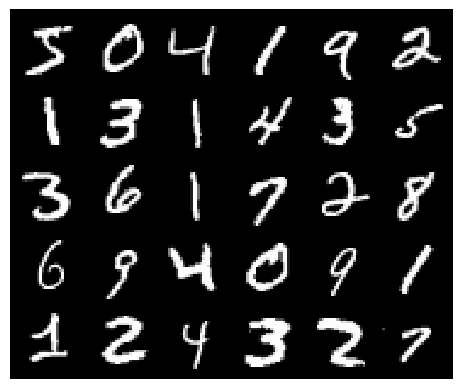

In [6]:
# Extract data and targets
x_train, y_train = dataset.data, dataset.targets

# Add a dimension to the tensor to become B*C*H*W
if len(x_train.shape) == 3:
      x_train = x_train.unsqueeze(1)
        
# Make a grid of 40 images, 8 images per row
x_grid = torchvision.utils.make_grid(x_train[:30], nrow=6, padding=2)

# Convert tensor to numpy array
npimg = x_grid.numpy()
# Convert to H*W*C shape
npimg_tr = np.transpose(npimg, (1, 2, 0))
plt.axis('off')
plt.imshow(npimg_tr, interpolation='nearest')

### Fashion-MNIST Dataset
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Source - https://www.kaggle.com/datasets/zalando-research/fashionmnist

In [7]:
transform=transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

dataset = datasets.FashionMNIST(root= '/kaggle/temp/', train = True, download =True, transform = transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [50000, 10000])

test_dataset = datasets.FashionMNIST(root= '/kaggle/temp', train = False, download =True, transform = transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 16285742.10it/s]


Extracting /kaggle/temp/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/temp/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 302159.09it/s]


Extracting /kaggle/temp/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/temp/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5588948.24it/s]


Extracting /kaggle/temp/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/temp/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10949430.52it/s]

Extracting /kaggle/temp/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/temp/FashionMNIST/raw



In [8]:
train_fmnist = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_fmnist = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_fmnist = DataLoader(test_dataset, batch_size=64, shuffle=False)

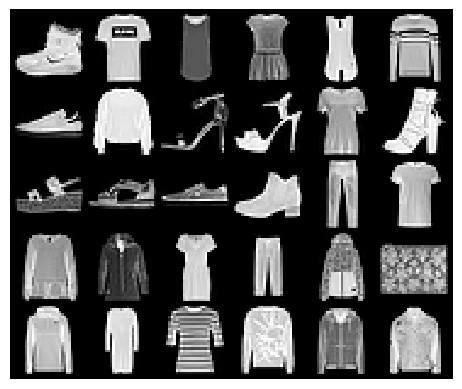

In [9]:
# Extract data and targets
x_train, y_train = dataset.data, dataset.targets

# Add a dimension to the tensor to become B*C*H*W
if len(x_train.shape) == 3:
      x_train = x_train.unsqueeze(1)
        
# Make a grid of 40 images, 8 images per row
x_grid = torchvision.utils.make_grid(x_train[:30], nrow=6, padding=2)

# Convert tensor to numpy array
npimg = x_grid.numpy()
# Convert to H*W*C shape
npimg_tr = np.transpose(npimg, (1, 2, 0))
plt.axis('off')
plt.imshow(npimg_tr, interpolation='nearest')

## VGG-16 : Transfer Learning
VGG16 [2] is object detection and classification algorithm which is able to classify 1000 images of 1000 different categories with 92.7% accuracy. It is one of the popular algorithms for image classification and is easy to use with transfer learning.
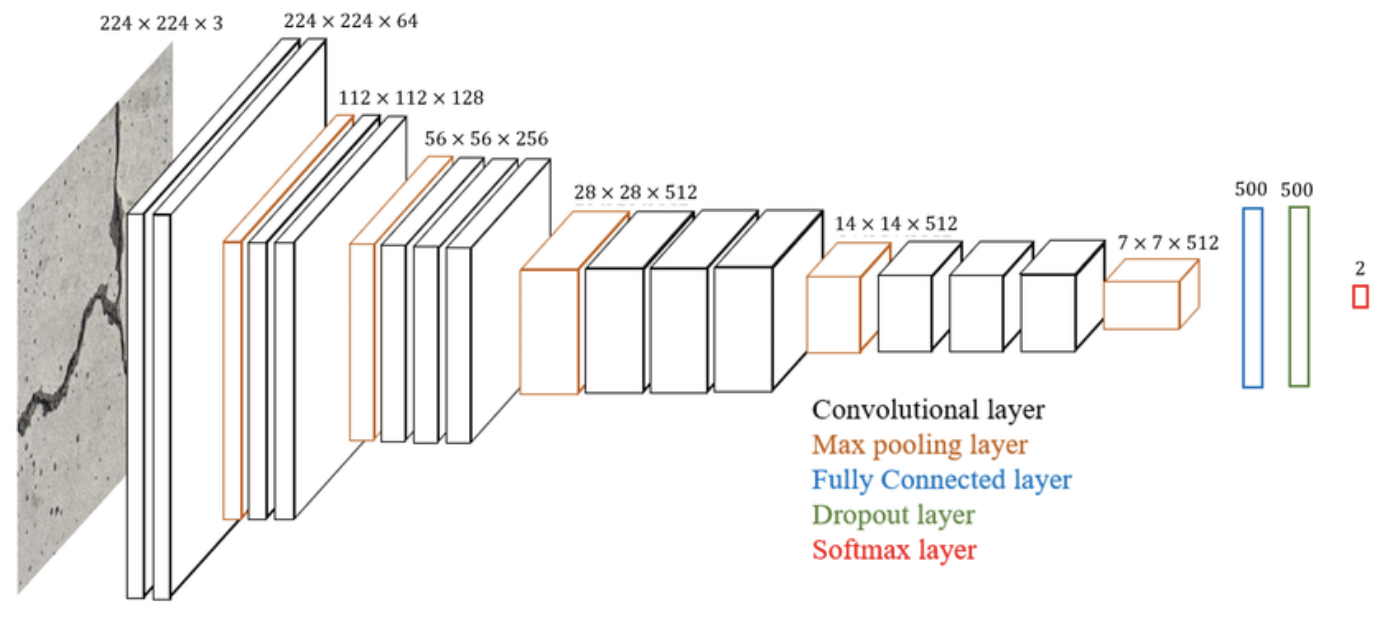

More details about how I have trained the model on the MNIST and Fashion-MNIST dataset can be found in this notebook - https://www.kaggle.com/code/shreyasi2002/vgg16-on-mnist-and-fashion-mnist

In [10]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1}

        noop = lambda x : x
        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels , **conv2_params)
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, **conv2_params)
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x
    

class VGG16(nn.Module):
    def __init__(self, input_size, num_classes=10, batch_norm=False):
        super(VGG16, self).__init__()

        self.in_channels, self.in_width, self.in_height = input_size

        self.block_1 = VGGBlock(self.in_channels, 64, batch_norm=batch_norm)
        self.block_2 = VGGBlock(64, 128, batch_norm=batch_norm)
        self.block_3 = VGGBlock(128, 256, batch_norm=batch_norm)
        self.block_4 = VGGBlock(256,512, batch_norm=batch_norm)

        self.classifier = nn.Sequential(
                nn.Linear(2048, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, num_classes) 
            )

    @property
    def input_size(self):
          return self.in_channels, self.in_width, self.in_height

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [11]:
# For MNIST
model_mnist = VGG16((1,32,32), batch_norm=True)
model_mnist.to(device)
# Load the saved checkpoint 
model_mnist.load_state_dict(torch.load('/kaggle/input/vgg16-models-mnist-fashion-mnist/vgg16_mnist_model.pth'))

# For Fashion-MNIST
model_fmnist = VGG16((1,32,32), batch_norm=True)
model_fmnist.to(device)
# Load the saved checkpoint 
model_fmnist.load_state_dict(torch.load('/kaggle/input/vgg16-models-mnist-fashion-mnist/vgg16_fashion-mnist_model.pth'))

<All keys matched successfully>

## FGSM (Fast Gradient Sign Method) Adversarial Attack
Goodfellow et.al. [3] exploited the linearity of neural networks in higher dimensions to enable effective adversarial training to efficiently compute an adversarial perturbation for a given image. Fast Gradient Sign Method solves computes ρ as : 
<br/>
$\rho = \epsilon \;sign(\nabla J(\theta, I_c, l))$
<br/>where gradient of cost function around the current value of model parameters 𝛉 w.r.t. I<sub>C</sub> and ϵ bounds the l-∞ norm.

Find more details about FGSM attack in my notebook - https://www.kaggle.com/code/shreyasi2002/fgsm-attack-on-mnist-and-fashion-mnist-dataset

In [12]:
def perturb(imgs, eps, data_grads):
    # Collect the element-wise sign of the data gradient
    sign_data_grads = data_grads.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    adv_imgs = imgs + eps * sign_data_grads
    # Adding clipping to maintain [0,1] range
    adv_imgs = torch.clamp(adv_imgs, 0, 1)
    # Return the perturbed image
    return adv_imgs

def fgsm_attack(model, imgs, labels, eps):
    imgs.required_grad = True
    
    outputs = model(imgs)
    loss = F.nll_loss(outputs, labels)
    
    model.zero_grad()
    loss.backward()
    data_grads = imgs.grad.data
    
    adv_imgs = perturb(imgs, eps, data_grads)
    outputs = model(adv_imgs)
    new_preds = outputs.argmax(axis=1)
    
    return adv_imgs, new_preds

## PGD (Projected Gradient Descent) Attack
PGD adversarial attack was originally proposed by Madry et al. [4] as the most strongest “first-order adversarial” attack. Actually PGD is a well-known optimization technique projecting gradients in a ball. PGD is basically the same as BIM, described above, except that PGD starts at a random point in the ball and perform random restarts.

Find more details about PGD Attack here - https://www.kaggle.com/code/shreyasi2002/pgd-attack-on-mnist-and-fashion-mnist/notebook

In [13]:
def pgd_linf(model, imgs, labels, epsilon, alpha, num_iter, flag=0):
    """ Construct PGD adversarial examples on the examples X"""
    delta = torch.zeros_like(imgs, requires_grad=True)
    if flag == 1:
        num_iter = 1
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(imgs + delta), labels)
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
        new_preds = model(imgs + delta).argmax(axis=1)
    return (imgs + delta).detach(), new_preds

Since the PGD attacked adversarial examples are more natural-looking, I have created a dataset with the adversarial examples for the MNIST Dataset. Feel free to play around with it :)

Dataset - https://www.kaggle.com/datasets/shreyasi2002/corrupted-mnist

## Convolutional Auto-Encoder : Defending against Adversarial Attacks
An U-shaped convolutional auto-encoder is used to reconstruct original input from the adversarial image, effectively removing the adversarial perturbations. The goal of the autoencoder network is to minimise the mean squared error loss between the original unperturbed image and the reconstructed image, which is generated using an adversarial example. While doing so, a random Gaussian noise is added after encoding the image so as to make the model more robust. The idea behind adding the noise is to perturb the latent representation by a small magnitude, and then decode the perturbed latent representation, akin to how the adversarial examples are generated in the first place.

The GELU [5] activation layers are used in the model architecture. GELU being a smoother activation function having a non-zero derivative for all inputs helps to address the dying ReLU problem and allow for more effective learning in deep neural networks.

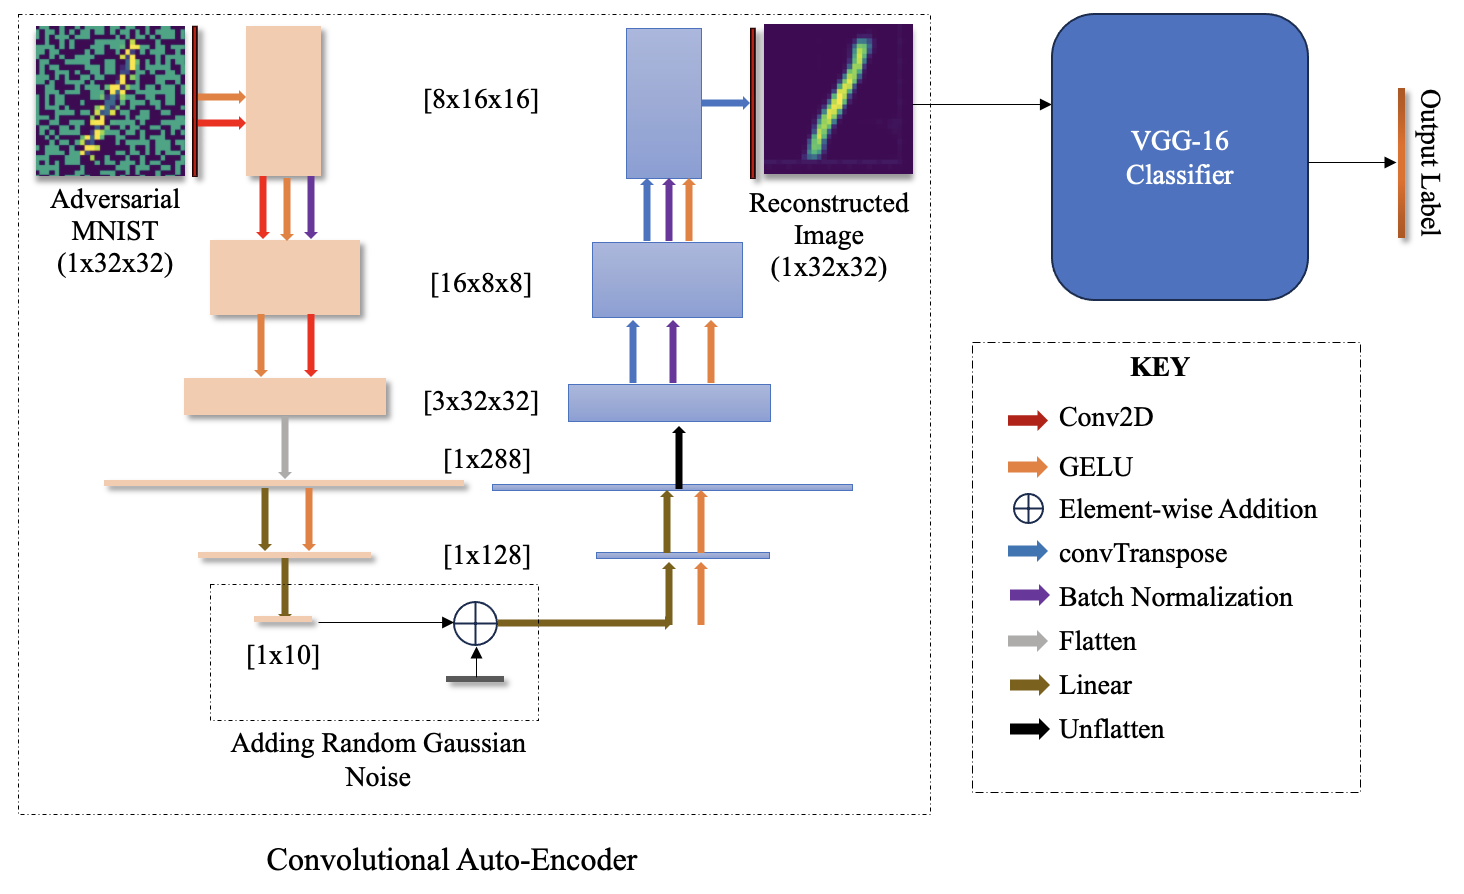

In [14]:
class ConvAutoencoder_GELU(nn.Module):
    def __init__(self, device, z_dim=10):
        super().__init__()
        self.device = device

        self.encoder_conv2D = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.GELU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.GELU()
        )

        ## Flatten Layer
        self.flatten = nn.Flatten(start_dim=1)
        
        ## Linear Section
        self.encoder_linear = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.GELU(),
            nn.Linear(128, z_dim),
        )

        self.decoder_linear = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.GELU(),
            nn.Linear(128, 3 * 3 * 32),
            nn.GELU(),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        
        self.decoder_convt2d = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.GELU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
        )


    def forward(self, x):
        ## Encode the image to latent space
        x = self.encoder_conv2D(x)
        x = self.flatten(x)
        x = self.encoder_linear(x)

        ## Add random gaussian noise to latent encoding
        noise = torch.randn(x.shape).to(self.device)
        x = x + noise

        ## Decode the latent encoding back to reconstructed image
        x = self.decoder_linear(x)
        x = self.unflatten(x)
        x = self.decoder_convt2d(x)
        x = torch.sigmoid(x)
                
        return x

In [15]:
convAE = ConvAutoencoder_GELU(device)
convAE.to(device)

# Summary of the model architecture
summary(convAE, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]              80
              GELU-2            [-1, 8, 16, 16]               0
            Conv2d-3             [-1, 16, 8, 8]           1,168
       BatchNorm2d-4             [-1, 16, 8, 8]              32
              GELU-5             [-1, 16, 8, 8]               0
            Conv2d-6             [-1, 32, 3, 3]           4,640
              GELU-7             [-1, 32, 3, 3]               0
           Flatten-8                  [-1, 288]               0
            Linear-9                  [-1, 128]          36,992
             GELU-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
           Linear-12                  [-1, 128]           1,408
             GELU-13                  [-1, 128]               0
           Linear-14                  [

### Early Stopping Criterion
Implementing early stopping to prevent overfitting

In [16]:
class EarlyStopping:
    def __init__(self, tolerance=2, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True
                
early_stopping = EarlyStopping()

### Training the Auto-Encoder on the Adversarial examples

In [17]:
def load_checkpoint(checkpoint):
    convAE.load_state_dict(checkpoint['convAE_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['train_losses'], checkpoint['val_losses']

def save_checkpoint(checkpoint, model_path):
    torch.save(checkpoint, model_path)

In [18]:
def train(model, num_epochs, attack_type, train_loader, val_loader, load_model=False, file_path='/kaggle/working/ae_mnist_fgsm.pth.tar'):
    train_losses, val_losses = [], []
    if load_model:
        train_losses, val_losses = load_checkpoint(torch.load(file_path))
        print("Loaded pre-trained model ...")
    
    start_epoch = len(train_losses)
    start_time = time.time()
    
    for epoch in range(start_epoch, num_epochs):
        train_loss, val_loss = 0.0, 0.0
        train_count, val_count = 0, 0
        for _, (imgs, labels) in enumerate(train_loader):
            batch_size = imgs.shape[0]
            imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))

            if attack_type == 'fgsm':
                adv_imgs, _ = fgsm_attack(model, imgs, labels, eps_fgsm)
            else:
                adv_imgs, _ = pgd_linf(model, imgs, labels, eps_pgd, alpha, num_iter)
            
            train_count += len(adv_imgs)

            adv_imgs = adv_imgs.to(device)

            optimizer.zero_grad()
            rec_imgs = convAE.forward(adv_imgs)
            loss = criterion(imgs, rec_imgs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_size

        for _, (imgs, labels) in enumerate(val_loader):
            batch_size = imgs.shape[0]
            imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))
            if attack_type == 'fgsm':
                adv_imgs, _ = fgsm_attack(model, imgs, labels, eps_fgsm)
            else:
                adv_imgs, _ = pgd_linf(model, imgs, labels, eps_pgd, alpha, num_iter)
            
            val_count += len(adv_imgs)

            adv_imgs = adv_imgs.to(device)

            optimizer.zero_grad()
            rec_imgs = convAE.forward(adv_imgs)
            loss = criterion(imgs, rec_imgs)
            loss.backward()
            optimizer.step()
            val_loss += loss.item() * batch_size

        train_loss, val_loss = train_loss / train_count, val_loss / val_count

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch+1} / {num_epochs}, Train_loss: {train_loss:.4f}, Val_loss: {val_loss:.4f}, \
              Time_taken: {(time.time()-start_time)/60:.2f} mins')

        checkpoint = {
            'convAE_state_dict': convAE.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses, 'val_losses': val_losses
        }

        save_checkpoint(checkpoint, file_path)
        early_stopping(train_loss, val_loss)
        if early_stopping.early_stop:
            print("Early Stopping critieria satisfied")
            break
            
    # Plot the training and validation loss
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('number of epochs')
    plt.legend()

    plt.show()
    plt.close()

In [19]:
def to_numpy_array(tensor):
    '''Convert torch.Tensor to np.ndarray'''
    tensor_ = tensor.cpu()
    tensor_ = tensor_.squeeze(0)
    tensor_ = tensor_.detach().numpy()
    return tensor_

# Visualise the reconstructed image
def visualise(model, val_loader, attack_type):
    count = 0
    for i, (imgs, labels) in enumerate(val_loader):
        if count > 4:
            break
        if i % 3 == 0:
            count += 1
            batch_size = imgs.shape[0]
            imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))

            if attack_type == 'fgsm':
                adv_imgs, _ = fgsm_attack(model, imgs, labels, eps_fgsm)
            else:
                adv_imgs, _ = pgd_linf(model, imgs, labels, eps_pgd, alpha, num_iter)

            adv_imgs = adv_imgs.to(device)

            with torch.no_grad():
                rec_imgs = convAE(adv_imgs)

            imgs, adv_imgs, rec_imgs = to_numpy_array(imgs[0]), to_numpy_array(adv_imgs[0]), to_numpy_array(rec_imgs[0])

            f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
            ax1.imshow(adv_imgs)
            ax1.set_title("Adversarial Image")
            ax2.imshow(rec_imgs)
            ax2.set_title("Recreated Image")
            ax3.imshow(imgs)
            ax3.set_title("Original Image")

In [20]:
# Parameters
lr = 0.001
batch_size = 64
num_epochs = 15
z_dim = 10

# FGSM parameters
eps_fgsm = 0.6

# PGD parameters
eps_pgd, alpha, num_iter = 0.15, 1e-2, 40

In [21]:
# Loss function
criterion = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(convAE.parameters(), lr=lr)

Epoch: 1 / 15, Train_loss: 0.0587, Val_loss: 0.0276,               Time_taken: 0.54 mins
Epoch: 2 / 15, Train_loss: 0.0228, Val_loss: 0.0202,               Time_taken: 1.07 mins
Epoch: 3 / 15, Train_loss: 0.0188, Val_loss: 0.0178,               Time_taken: 1.59 mins
Epoch: 4 / 15, Train_loss: 0.0171, Val_loss: 0.0165,               Time_taken: 2.12 mins
Epoch: 5 / 15, Train_loss: 0.0161, Val_loss: 0.0157,               Time_taken: 2.64 mins
Epoch: 6 / 15, Train_loss: 0.0154, Val_loss: 0.0151,               Time_taken: 3.17 mins
Epoch: 7 / 15, Train_loss: 0.0149, Val_loss: 0.0146,               Time_taken: 3.69 mins
Epoch: 8 / 15, Train_loss: 0.0145, Val_loss: 0.0143,               Time_taken: 4.22 mins
Epoch: 9 / 15, Train_loss: 0.0142, Val_loss: 0.0140,               Time_taken: 4.75 mins
Epoch: 10 / 15, Train_loss: 0.0139, Val_loss: 0.0138,               Time_taken: 5.27 mins
Epoch: 11 / 15, Train_loss: 0.0136, Val_loss: 0.0134,               Time_taken: 5.80 mins
Epoch: 12 / 15, Tra

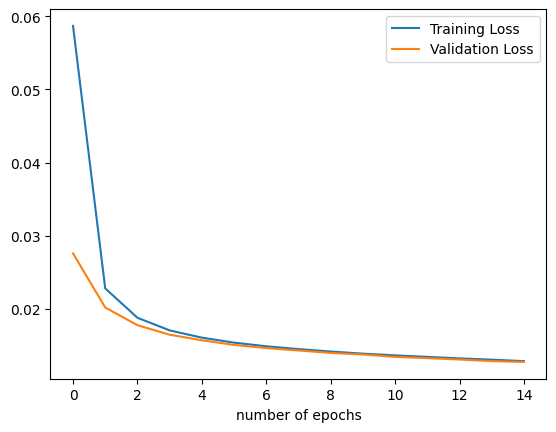

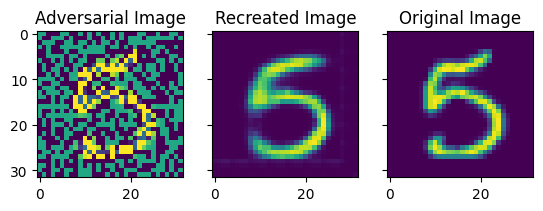

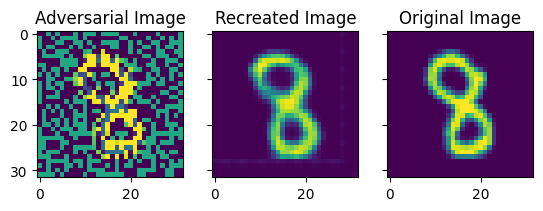

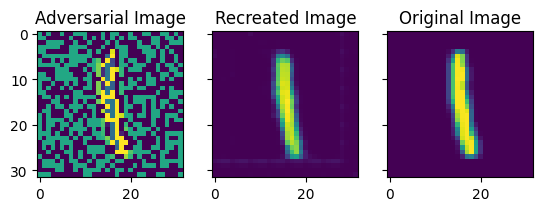

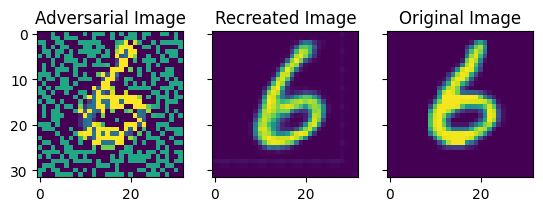

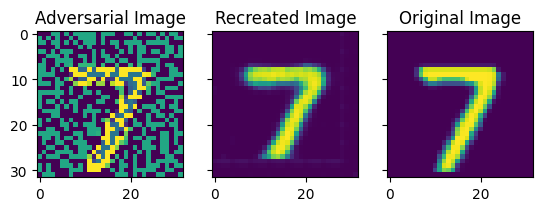

In [22]:
# FGSM Attack on the MNIST Dataset
attack_type = 'fgsm'
file_path = '/kaggle/working/ae_mnist_fgsm.pth.tar'
train(model_mnist, num_epochs, attack_type, train_mnist, val_mnist, load_model=False, file_path=file_path)
visualise(model_mnist, val_mnist, attack_type)

Epoch: 1 / 15, Train_loss: 0.0319, Val_loss: 0.0282,               Time_taken: 0.52 mins
Epoch: 2 / 15, Train_loss: 0.0274, Val_loss: 0.0268,               Time_taken: 1.05 mins
Epoch: 3 / 15, Train_loss: 0.0264, Val_loss: 0.0261,               Time_taken: 1.57 mins
Epoch: 4 / 15, Train_loss: 0.0257, Val_loss: 0.0254,               Time_taken: 2.09 mins
Epoch: 5 / 15, Train_loss: 0.0251, Val_loss: 0.0250,               Time_taken: 2.63 mins
Epoch: 6 / 15, Train_loss: 0.0248, Val_loss: 0.0246,               Time_taken: 3.16 mins
Epoch: 7 / 15, Train_loss: 0.0245, Val_loss: 0.0243,               Time_taken: 3.69 mins
Epoch: 8 / 15, Train_loss: 0.0243, Val_loss: 0.0241,               Time_taken: 4.22 mins
Epoch: 9 / 15, Train_loss: 0.0241, Val_loss: 0.0240,               Time_taken: 4.75 mins
Epoch: 10 / 15, Train_loss: 0.0239, Val_loss: 0.0238,               Time_taken: 5.28 mins
Epoch: 11 / 15, Train_loss: 0.0238, Val_loss: 0.0237,               Time_taken: 5.80 mins
Epoch: 12 / 15, Tra

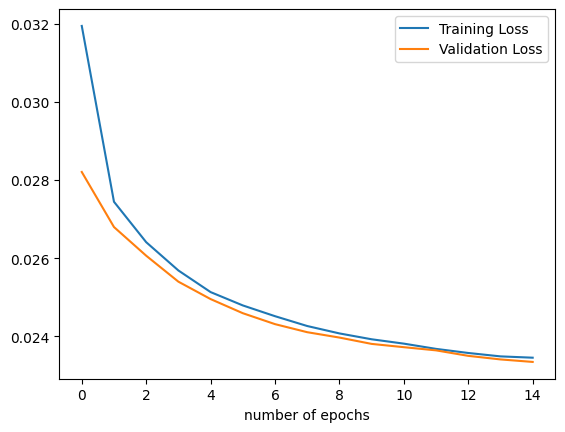

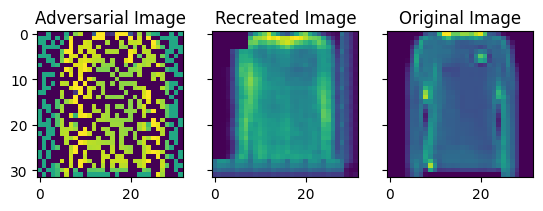

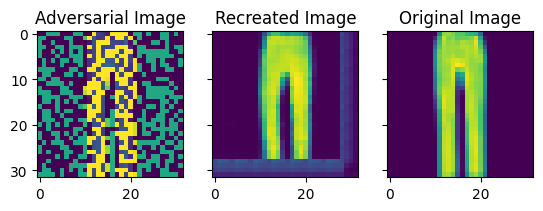

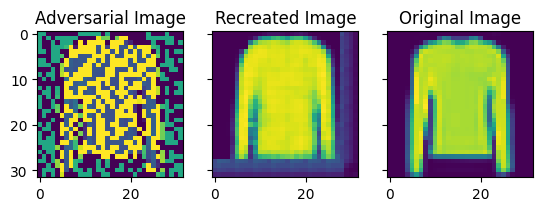

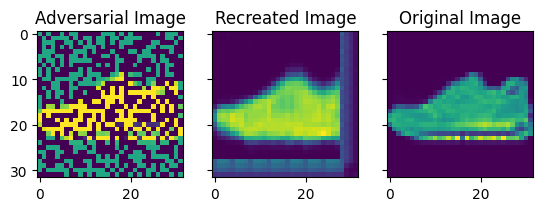

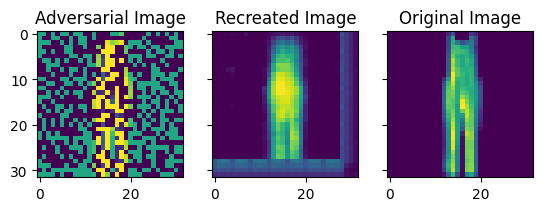

In [23]:
# FGSM Attack on the Fashion-MNIST Dataset
file_path = '/kaggle/working/ae_fmnist_fgsm.pth.tar'
train(model_fmnist, num_epochs, attack_type, train_fmnist, val_fmnist, load_model=False, file_path=file_path)
visualise(model_fmnist, val_fmnist, attack_type)

Epoch: 1 / 5, Train_loss: 0.0186, Val_loss: 0.0145,               Time_taken: 12.89 mins
Epoch: 2 / 5, Train_loss: 0.0135, Val_loss: 0.0128,               Time_taken: 25.78 mins
Epoch: 3 / 5, Train_loss: 0.0124, Val_loss: 0.0121,               Time_taken: 38.70 mins
Epoch: 4 / 5, Train_loss: 0.0118, Val_loss: 0.0116,               Time_taken: 51.60 mins
Epoch: 5 / 5, Train_loss: 0.0114, Val_loss: 0.0112,               Time_taken: 64.49 mins


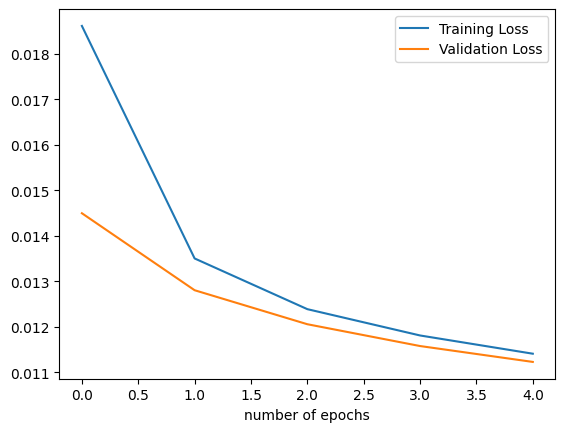

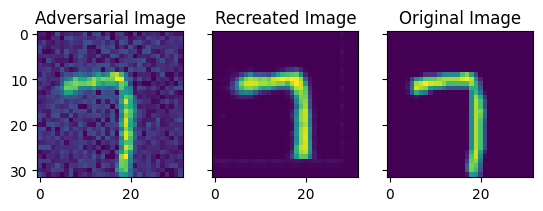

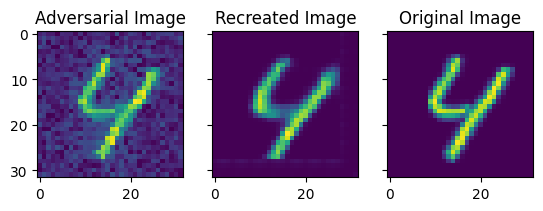

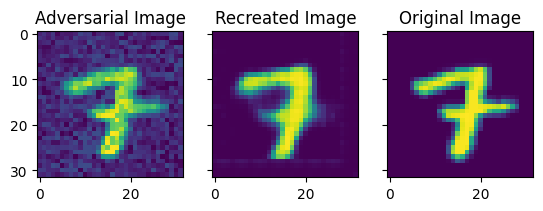

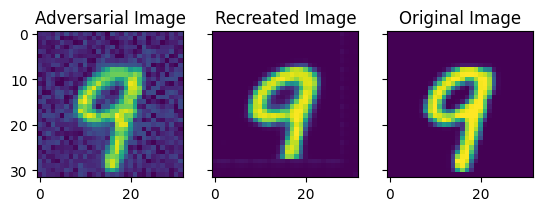

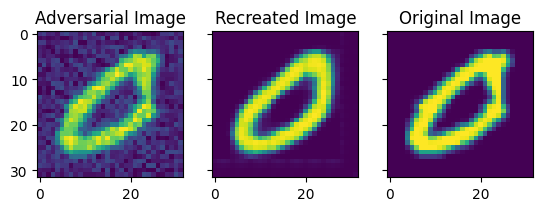

In [24]:
# PGD Attack on the MNIST Dataset
attack_type = 'pgd'
file_path = '/kaggle/working/ae_mnist_pgd.pth.tar'
train(model_mnist, 5, attack_type, train_mnist, val_mnist, load_model=False, file_path=file_path)
visualise(model_mnist, val_mnist, attack_type)

Epoch: 1 / 5, Train_loss: 0.0266, Val_loss: 0.0241,               Time_taken: 12.89 mins
Epoch: 2 / 5, Train_loss: 0.0237, Val_loss: 0.0234,               Time_taken: 25.79 mins
Epoch: 3 / 5, Train_loss: 0.0232, Val_loss: 0.0230,               Time_taken: 38.68 mins
Epoch: 4 / 5, Train_loss: 0.0229, Val_loss: 0.0228,               Time_taken: 51.56 mins
Epoch: 5 / 5, Train_loss: 0.0227, Val_loss: 0.0227,               Time_taken: 64.49 mins


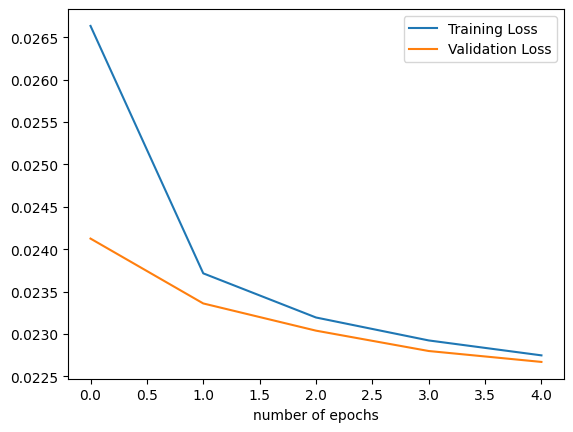

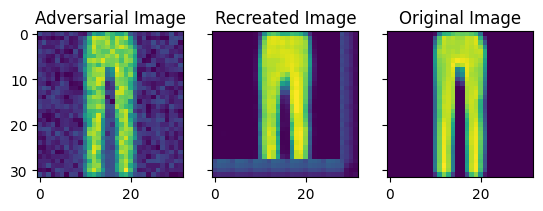

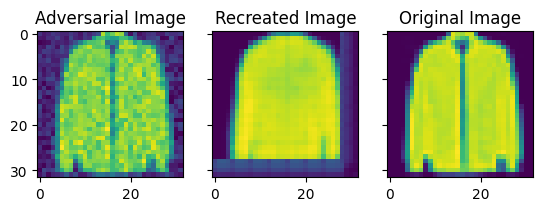

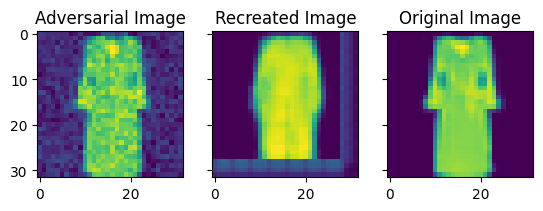

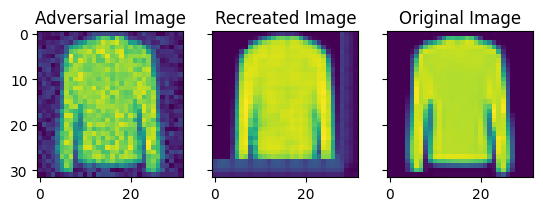

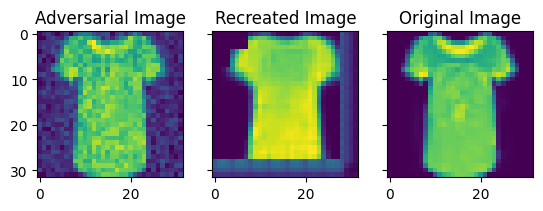

In [25]:
# PGD Attack on the Fashion-MNIST Dataset
file_path = '/kaggle/working/ae_fmnist_pgd.pth.tar'
train(model_fmnist, 5, attack_type, train_fmnist, val_fmnist, load_model=False, file_path=file_path)
visualise(model_fmnist, val_fmnist, attack_type)

## Performance of the proposed architecture - Accuracy and Inference Time

In [26]:
def test(model, test_loader, attack_type, file_path):
    convAE = ConvAutoencoder_GELU(device)
    convAE.to(device)
    convAE.load_state_dict(torch.load(file_path)['convAE_state_dict'])
    
    correct, total = 0, 0
    
    tot_time = 0

    for _, (imgs, labels) in enumerate(test_loader):
        batch_size = imgs.shape[0]
        imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))

        if attack_type == 'fgsm':
            adv_imgs, _ = fgsm_attack(model, imgs, labels, eps_fgsm)
        else:
            adv_imgs, _ = pgd_linf(model, imgs, labels, eps_pgd, alpha, num_iter)

        adv_imgs = adv_imgs.to(device)
        
        time_comp = time.time()

        with torch.no_grad():
            rec_imgs = convAE(adv_imgs)

        y_preds = model(rec_imgs).argmax(dim=1)
        correct += (y_preds == labels).sum().item()
        total += labels.size(0)
        
        tot_time += (time.time() - time_comp)

    print("Test Accuracy: {}".format(correct / total))
    print(f'Time taken for defense against a single instance of attack: {(tot_time)/10000:.4f} sec')
    print(f'Total time taken: {tot_time:.4f} sec')

In [27]:
# Test on the MNIST Dataset with FGSM Attack
attack_type = 'fgsm'
file_path = '/kaggle/working/ae_mnist_fgsm.pth.tar'
test(model_mnist, test_mnist, attack_type, file_path)

Test Accuracy: 0.916
Time taken for defense against a single instance of attack: 0.0003 sec
Total time taken: 2.8159 sec


In [28]:
# Test on the Fashion-MNIST Dataset with FGSM Attack
file_path = '/kaggle/working/ae_fmnist_fgsm.pth.tar'
test(model_fmnist, test_fmnist, attack_type, file_path)

Test Accuracy: 0.7286
Time taken for defense against a single instance of attack: 0.0003 sec
Total time taken: 2.8219 sec


In [29]:
# Test on the MNIST Dataset with PGD Attack
attack_type = 'pgd'
file_path = '/kaggle/working/ae_mnist_pgd.pth.tar'
test(model_mnist, test_mnist, attack_type, file_path)

Test Accuracy: 0.9366
Time taken for defense against a single instance of attack: 0.0012 sec
Total time taken: 11.8059 sec


In [30]:
# Test on the Fashion-MNIST Dataset with PGD Attack
file_path = '/kaggle/working/ae_fmnist_pgd.pth.tar'
test(model_fmnist, test_fmnist, attack_type, file_path)

Test Accuracy: 0.7027
Time taken for defense against a single instance of attack: 0.0012 sec
Total time taken: 11.8129 sec


## Results
The accuracy of the pre-trained VGG-16 classifier on the MNIST and Fashion-MNIST dataset with FGSM attack
increases by 65.61% and 59.76% respectively. For the PGD attack, the accuracy increases by 89.88% and
43.49%. This shows the efficacy of our model in defending the adversarial attacks with high accuracy.

<table>
    <thead>
        <tr>
            <td><b>Attack</b></td>
            <td colspan=2><b>Accuracy (w/o defense)</b></td>
            <td colspan=2><b>Accuracy (with defense)</b></td>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td></td>
            <td>MNIST</td>
            <td>Fashion-MNIST</td>
            <td>MNIST</td>
            <td>Fashion-MNIST</td>
        </tr>
        <tr>
            <td>FGSM (ε = 0.60)</td>
            <td>0.2648</td>
            <td>0.1417</td>
            <td>0.9209</td>
            <td>0.7393</td>
        </tr>
        <tr>
            <td>PGD (ε = 0.15)</td>
            <td>0.0418</td>
            <td>0.2942</td>
            <td>0.9406</td>
            <td>0.7291</td>
        </tr>
    </tbody>
</table>


## References
1. Intriguing properties of neural networks - Christian Szegedy, Wojciech Zaremba, Ilya Sutskever, Joan Bruna, Dumitru Erhan, Ian Goodfellow, Rob Fergus (https://arxiv.org/abs/1312.6199)
2. K. Simonyan and A. Zisserman, “Very deep convolutional networks for large-scale image recognition,” arXiv preprint arXiv:1409.1556, 2014
3. Explaining and Harnessing Adversarial Examples - Ian J. Goodfellow, Jonathon Shlens, Christian Szegedy (https://arxiv.org/abs/1412.6572)
4. A. Madry, A. Makelov, L. Schmidt, D. Tsipras and A. Vladu, "Towards deep learning models resistant to adversarial attacks", arXiv preprint, 2017.
5. D. Hendrycks and K. Gimpel, “Gaussian error linear units (gelus),” 2020
6. P. Samangouei, M. Kabkab, and R. Chellappa, “Defense-gan: Protecting classifiers against adversarial attacks using generative models,” CoRR, vol. abs/1805.06605, 2018
7. U. Hwang, J. Park, H. Jang, S. Yoon, and N. I. Cho, “Puvae: A variational autoencoder to purify adversarial examples,” CoRR, vol. abs/1903.00585, 2019